In [1]:
pip install git+https://github.com/jkirkby3/pymle.git

  Cloning https://github.com/jkirkby3/pymle.git to /private/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/pip-req-build-byad3k7m
  Running command git clone --filter=blob:none --quiet https://github.com/jkirkby3/pymle.git /private/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/pip-req-build-byad3k7m
  Resolved https://github.com/jkirkby3/pymle.git to commit 412f74f5201782686f13ed2c60acd07b740c42e8
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import numpy as np
import numpy.random as rnd
import matplotlib.pyplot as plt
import pandas as pd
import time
import numpy as np, scipy.stats as st
import matplotlib.dates as mdates
from scipy.stats import norm
from tqdm import tqdm
from pymle.models import CIR, CKLS, OrnsteinUhlenbeck
from pymle.sim.Simulator1D import Simulator1D
from pymle.core.TransitionDensity import ExactDensity, KesslerDensity, OzakiDensity, EulerDensity, ShojiOzakiDensity
from pymle.fit.AnalyticalMLE import AnalyticalMLE

In [2]:
# Define auxiliary function to find minimal value
def argmin(iterable):
    return min(enumerate(iterable), key=lambda x: x[1])[0]

Task 1. Constant Maturity Interest Rates. Fit models (CEV, CIR, OU, CKLS) to a sample of historical interest rates over the period Jan 1, 1962 to till now. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using MLE approach.

The estimated parameters display in a table for each method. Calculate the AIC and select the best model. Compare your results with paper by Kirkby et. al (https://arxiv.org/abs/2108.12649) where the period from Jan 1, 1962 to April 8, 2021 (14,801 daily observations).

Dataset: Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity, Quoted on an Investment Basis (DGS10),
https://fred.stlouisfed.org/series/DGS10  

In [3]:
# Read data and preprocessing it
df_IR = pd.read_csv('DGS10.csv')
df_IR = df_IR[df_IR['DGS10'] != '.']

# Make valid numerical sample
sample = df_IR['DGS10'].values
sample = [float(sample[i]) for i in range(len(sample))]
sample = np.array(sample)

Task. Download the DGS10 dataset directlly from https://fred.stlouisfed.org/series/DGS10 .

Hint.

Use  
`from pymle.data.loader import load_10yr_CMrate`

In [4]:
# your code
from pymle.data.loader import load_10yr_CMrate

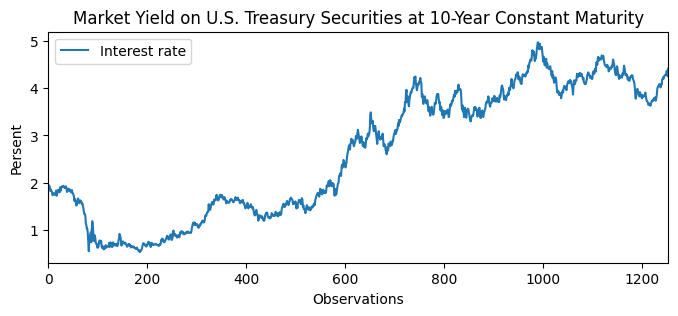

In [5]:
# Plot
figure, ax = plt.subplots(figsize=(8,3))
ax.plot(np.linspace(0, len(sample), len(sample)),sample, label='Interest rate')
plt.title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
plt.xlim(0, len(sample))
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.show()

Task. Change the X marks to dates.

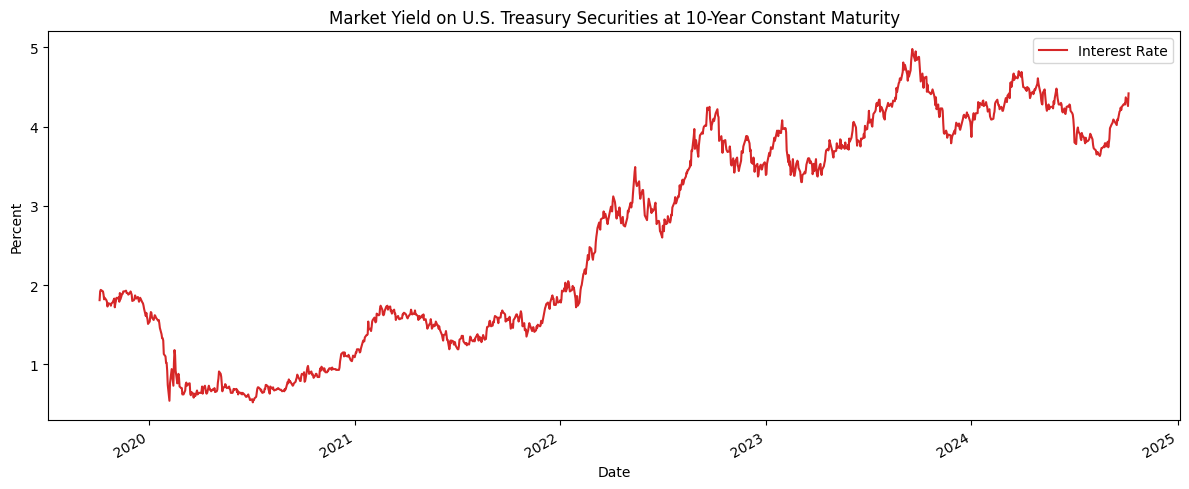

In [8]:
df_IR['DATE'] = pd.to_datetime(df_IR['DATE'], errors='coerce')
df_IR = df_IR.dropna(subset=['DATE'])

dates = df_IR['DATE']

fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(dates, sample, label='Interest Rate', color='tab:red', linewidth=1.5)

#ax.xaxis.set_major_locator(mdates.YearLocator())  
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))  
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  
fig.autofmt_xdate()

ax.set_title('Market Yield on U.S. Treasury Securities at 10-Year Constant Maturity')
ax.set_xlabel('Date')
ax.set_ylabel('Percent')
ax.legend()
plt.tight_layout()
plt.show()

In [34]:
# Import models for fitting:
from pymle.models import BrownianMotion, CEV, CIR,\
                         CKLS, GeometricBM, IGBM, \
                         OrnsteinUhlenbeck

In [10]:
# a) fit using Kessler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252

# Estimate max likelyhood, using KesslerDensity
kessler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
kessler_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=KesslerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 99, CG iterations: 50, optimality: 6.93e-04, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.52577211 0.99606105]
Final Likelihood: 1688.5031351385865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 620, CG iterations: 411, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [0.04021861 0.41865339 0.7990315  0.24315419]
Final Likelihood: 1713.14808573056
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 276, CG iterations: 88, optimality: 2.81e+00, constraint violation: 0.00e+00, execution time: 0.07 s.
Final Params: [0.03191792 0.97228134 0.6842959 ]
Final Likelihood: 1668.8177223246507
Initial Params: [0.01, 0.2]
Initial Likelihood: -952.570413375402
`xtol` termination condition is satisfied.
Number of iterations: 20, function evaluations: 30, CG iterations: 19, optimality: 2.24e+02, constraint violation: 0.00e+00, execution time: 0.011 s.
Final Params: [0.33961232 0.82111567]
Final Likelihood: 1245.9490235547728
Initial Params: [0.01, 

In [11]:
best_ind = argmin(kessler_est)
print("AIC values for Kessler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     kessler_est[0], model_name[0], kessler_params[0],\
     kessler_est[1], model_name[1], kessler_params[1],\
     kessler_est[2], model_name[2], kessler_params[2],\
     kessler_est[3], model_name[3], kessler_params[3],\
     kessler_est[4], model_name[4], kessler_params[4],\
     kessler_est[5], model_name[5], kessler_params[5],\
     kessler_est[6], model_name[6], kessler_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], kessler_params[best_ind]))

AIC values for Kessler estimation:
       -3373.006 - BrownianMotion model with params [0.52577211 0.99606105],
       -3418.296 - CEV model with params [0.04021861 0.41865339 0.7990315  0.24315419],
       -3331.635 - CIR model with params [0.03191792 0.97228134 0.6842959 ],
       -2487.898 - GeometricBM model with params [0.33961232 0.82111567],
       -2712.736 - IGBM model with params [0.71909431 2.60390359 0.59091266],
       -3371.151 - OrnsteinUhlenbeck model with params [0.12776936 6.72061882 0.9960037 ],
       -3420.939 - CKLS model with params [0.3913957  0.05389653 0.81633816 0.227809  ],
       
The best model is CKLS     with param [0.3913957  0.05389653 0.81633816 0.227809  ]


In [12]:
# b) fit using Shoji-Ozaki method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
shoji_ozaki_est      = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
shoji_ozaki_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=ShojiOzakiDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 96, CG iterations: 58, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.055 s.
Final Params: [0.52575747 0.99606106]
Final Likelihood: 1688.5031351392577
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.5899890722
`xtol` termination condition is satisfied.
Number of iterations: 177, function evaluations: 895, CG iterations: 418, optimality: 1.23e-02, constraint violation: 0.00e+00, execution time: 0.28 s.
Final Params: [0.1546211  5.59349201 0.81911933 0.22427329]
Final Likelihood: 1714.547549995581
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.38146138146
`xtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 236, CG iterations: 131, optimality: 2.97e-02, constraint violation: 0.00e+00, execution time: 0.077 s.
Final Params: [0.13183693 6.4

In [13]:
best_ind = argmin(shoji_ozaki_est)
print("AIC values for Shoji-Ozaki estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     shoji_ozaki_est[0], model_name[0], shoji_ozaki_params[0],\
     shoji_ozaki_est[1], model_name[1], shoji_ozaki_params[1],\
     shoji_ozaki_est[2], model_name[2], shoji_ozaki_params[2],\
     shoji_ozaki_est[3], model_name[3], shoji_ozaki_params[3],\
     shoji_ozaki_est[4], model_name[4], shoji_ozaki_params[4],\
     shoji_ozaki_est[5], model_name[5], shoji_ozaki_params[5],\
     shoji_ozaki_est[6], model_name[6], shoji_ozaki_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], shoji_ozaki_params[best_ind]))

AIC values for Shoji-Ozaki estimation:
       -3373.006 - BrownianMotion model with params [0.52575747 0.99606106],
       -3421.095 - CEV model with params [0.1546211  5.59349201 0.81911933 0.22427329],
       -3334.047 - CIR model with params [0.13183693 6.41890795 0.68439077],
       -2708.611 - GeometricBM model with params [0.33959551 0.59468609],
       -2710.932 - IGBM model with params [0.44295554 3.07002563 0.59458243],
       -3371.127 - OrnsteinUhlenbeck model with params [0.07423731 9.87632162 0.99615935],
       -3421.059 - CKLS model with params [0.53380145 0.01002347 0.81881469 0.22433496],
       
The best model is CEV     with param [0.1546211  5.59349201 0.81911933 0.22427329]


In [14]:
# c) fit using Euler method:

# Choose several models:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", \
         "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), \
         IGBM(), OrnsteinUhlenbeck(), CKLS()]

# Create parametrization templates:
param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]

# Set parameters for estimators:
dt = 1. / 252
K = 1

# Estimate max likelyhood, using Shoji-Ozaki
euler_est   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).aic \
               for i in range (len(param_bounds))];
eu_params   = [AnalyticalMLE(sample, param_bounds[i], dt, density=EulerDensity(model[i])).estimate_params(param_guess[i]).params \
               for i in range (len(param_bounds))];

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678524914
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 120, CG iterations: 59, optimality: 1.01e-05, constraint violation: 0.00e+00, execution time: 0.055 s.
Final Params: [0.52575555 0.99606105]
Final Likelihood: 1688.5031351392681
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.45728481325
`xtol` termination condition is satisfied.
Number of iterations: 85, function evaluations: 365, CG iterations: 199, optimality: 1.14e-05, constraint violation: 0.00e+00, execution time: 0.11 s.
Final Params: [0.08517519 8.74375967 0.81883613 0.22428031]
Final Likelihood: 1714.5748785815742
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2722.1718500081256
`gtol` termination condition is satisfied.
Number of iterations: 61, function evaluations: 220, CG iterations: 124, optimality: 3.02e-07, constraint violation: 0.00e+00, execution time: 0.081 s.
Final Params: [0.10663215

In [15]:
best_ind = argmin(euler_est)
print("AIC values for Euler estimation:\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      {:.3f} - {} model with params {},\n \
      ".format(
     euler_est[0], model_name[0], eu_params[0],\
     euler_est[1], model_name[1], eu_params[1],\
     euler_est[2], model_name[2], eu_params[2],\
     euler_est[3], model_name[3], eu_params[3],\
     euler_est[4], model_name[4], eu_params[4],\
     euler_est[5], model_name[5], eu_params[5],\
     euler_est[6], model_name[6], eu_params[6]))

print("The best model is {} \
    with param {}".format(model_name[best_ind], eu_params[best_ind]))

AIC values for Euler estimation:
       -3373.006 - BrownianMotion model with params [0.52575555 0.99606105],
       -3421.150 - CEV model with params [0.08517519 8.74375967 0.81883613 0.22428031],
       -3334.053 - CIR model with params [0.10663215 7.54354313 0.68420268],
       -2708.614 - GeometricBM model with params [0.35406979 0.59508578],
       -2710.938 - IGBM model with params [0.41318322 3.24220985 0.59405827],
       -3371.151 - OrnsteinUhlenbeck model with params [0.12449787 6.83610016 0.99600334],
       -3421.059 - CKLS model with params [0.53384492 0.01000671 0.81883097 0.22433495],
       
The best model is CEV     with param [0.08517519 8.74375967 0.81883613 0.22428031]


In [16]:
print("For the best model {}\n \
    params are:\n \
    {},\n \
    {},\n \
    {}".format(
    model_name[best_ind],\
    kessler_params[best_ind],\
    shoji_ozaki_params[best_ind],\
    eu_params[best_ind]))

For the best model CEV
     params are:
     [0.04021861 0.41865339 0.7990315  0.24315419],
     [0.1546211  5.59349201 0.81911933 0.22427329],
     [0.08517519 8.74375967 0.81883613 0.22428031]


In [17]:
shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

Task: Rewrite code and pass estimated parameters programmatically.

In [18]:
class ParameterEstimator:
    def __init__(self, data, models, names, bounds, guesses, dt=1/252):
        self.data = data
        self.models = models
        self.names = names
        self.bounds = bounds
        self.guesses = guesses
        self.dt = dt
        self.results = {method: {} for method in ['Kessler', 'Shoji-Ozaki', 'Euler']}

    def _run_estimation(self, method, model, bounds, guess):
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Метод {method} не поддерживается.")
        
        estimator = AnalyticalMLE(self.data, bounds, self.dt, density)
        results = estimator.estimate_params(guess)
        return results.aic, results.params

    def estimate_all(self):
        for method in self.results:
            for index, model in enumerate(self.models):
                aic_value, parameters = self._run_estimation(
                    method, model, self.bounds[index], self.guesses[index]
                )
                self.results[method][self.names[index]] = {'aic': aic_value, 'params': parameters}

    def display_aic(self):
        for method, models in self.results.items():
            print(f"\n{'='*50}")
            print(f"AIC для метода {method}:")
            print(f"{'Модель':<25} {'AIC':<10} {'Параметры'}")
            print("-" * 50)
            for name in self.names:
                model_data = models.get(name, {})
                print(f"{name:<25} {model_data.get('aic', 'N/A'):<10.3f} {model_data.get('params', 'N/A')}")
            print("="*50)

    def find_optimal_model(self):
        for method, models in self.results.items():
            optimal_model = min(models, key=lambda model: models[model]['aic'])
            optimal_params = models[optimal_model]['params']
            print(f"\n{'='*50}")
            print(f"Оптимальная модель для метода {method}: {optimal_model}")
            print(f"Параметры: {optimal_params}")
            print("="*50)

    def summarize_best_models(self):
        optimal_models = {
            method: min(self.results[method], key=lambda model: self.results[method][model]['aic'])
            for method in ['Kessler', 'Shoji-Ozaki', 'Euler']
        }

        print(f"\n{'='*50}")
        print("Сводка лучших моделей по методам:")
        print(f"{'Метод':<20} {'Лучшая модель':<25} {'Параметры'}")
        print("-" * 50)
        for method, model_name in optimal_models.items():
            parameters = self.results[method][model_name]['params']
            print(f"{method:<20} {model_name:<25} {parameters}")
        print("="*50)

In [19]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


estimator = ParameterEstimator(sample, model, model_name, param_bounds, param_guess)

estimator.estimate_all()
estimator.display_aic()
estimator.find_optimal_model()
estimator.summarize_best_models()

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 99, CG iterations: 50, optimality: 6.93e-04, constraint violation: 0.00e+00, execution time: 0.049 s.
Final Params: [0.52577211 0.99606105]
Final Likelihood: 1688.5031351385865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 620, CG iterations: 411, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.04021861 0.41865339 0.7990315  0.24315419]
Final Likelihood: 1713.14808573056
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 276, CG iterations: 88, optimality: 2.81e+00, constraint violation: 0.00e+00, execution time: 0.071 s.
Final Params: [0.03191792 0.

In [20]:
# Generate a CEV process with estimated parameters
# Define auxiliary functions:
def Wiener_proc(N, T):
    W = np.zeros(N)
    delta = T / N
    sqrt_delta = np.sqrt(delta)
    for i in range (1, N):
        W[i] += W[i-1] + rnd.normal(0, sqrt_delta)
    return W

#  CEV process:
def CEV_pr(S, kappa, mu, sigma, gamma, dt, dW):
    dS = kappa * (mu - S) * dt + sigma * (S**gamma) * dW
    return dS

In [21]:
cW = [sample[i] - sample[i-1] for i in range(1, len(sample))]

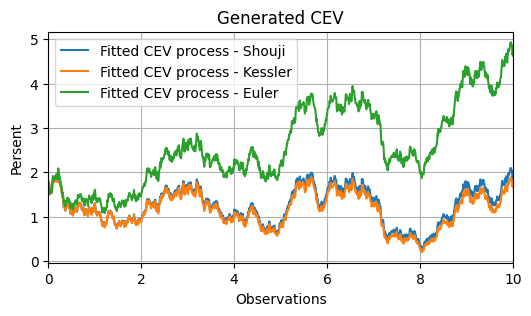

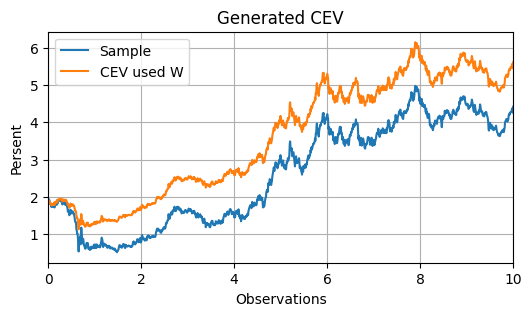

In [22]:
# Set data and generate the process:
T = 10
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
cev_s, cev_k, cev_e = np.zeros(N), np.zeros(N), np.zeros(N)
cev_s[0], cev_k[0], cev_e[0] = S0, S0, S0
ecev = np.zeros(N)
ecev[0] = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    cev_s[i] = cev_s[i-1] + CEV_pr(cev_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    cev_k[i] = cev_k[i-1] + CEV_pr(cev_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    cev_e[i] = cev_e[i-1] + CEV_pr(cev_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    ecev[i] = ecev[i-1] + CEV_pr(ecev[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, cev_s, label="Fitted CEV process - Shouji")
plt.plot(time_line, cev_k, label="Fitted CEV process - Kessler")
plt.plot(time_line, cev_e, label="Fitted CEV process - Euler")
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, ecev, label='CEV used W')
plt.title("Generated CEV")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Generate a CKLS process with estimated parameters.

In [23]:
def CKLS_process(S, kappa, mu, sigma, gamma, dt, dW):
    S_non_neg = np.maximum(S, 1e-6)  
    dS = kappa * (mu - S) * dt + sigma * (S_non_neg**gamma) * dW
    return dS

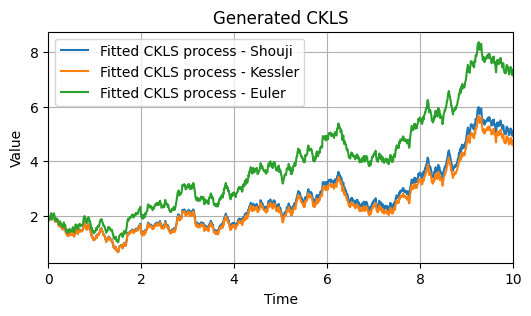

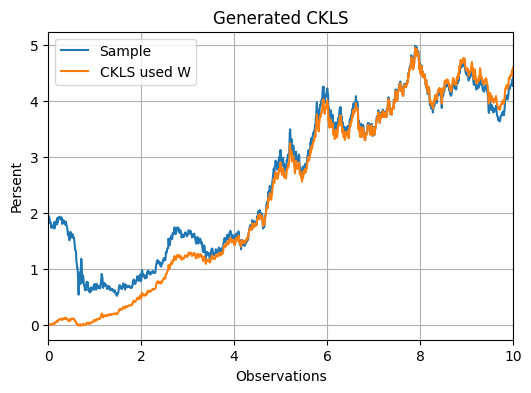

In [24]:
T = 10
N = len(sample)

S0 = sample[0]
# Set params that were fitted:
#kappa, mu, sigma, gamma = shoji_ozaki_p
kappa, mu, sigma, gamma = kessler_p
#kappa, mu, sigma, gamma = euler_p
time_line, dt = np.linspace(0, T, N, retstep=True)
W = Wiener_proc(N, T)
ckls_s, ckls_k, ckls_e = np.zeros(N), np.zeros(N), np.zeros(N)
ckls_s[0], ckls_k[0], ckls_e[0] = S0, S0, S0
eckls = np.zeros(N)
eckls0 = S0

for i in range(1, N):
    dW = W[i] - W[i-1]
    ckls_s[i] = ckls_s[i-1] + CKLS_process(ckls_s[i-1], shoji_ozaki_p[0], shoji_ozaki_p[1], shoji_ozaki_p[2], shoji_ozaki_p[3], dt, dW)
    ckls_k[i] = ckls_k[i-1] + CKLS_process(ckls_k[i-1], kessler_p[0], kessler_p[1], kessler_p[2], kessler_p[3], dt, dW)
    ckls_e[i] = ckls_e[i-1] + CKLS_process(ckls_e[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, dW)
    eckls[i] = eckls[i-1] + CKLS_process(eckls[i-1], euler_p[0], euler_p[1], euler_p[2], euler_p[3], dt, cW[i-1])

ax, figure = plt.subplots(figsize=(6, 3))
plt.plot(time_line, ckls_s, label="Fitted CKLS process - Shouji")
plt.plot(time_line, ckls_k, label="Fitted CKLS process - Kessler")
plt.plot(time_line, ckls_e, label="Fitted CKLS process - Euler")
plt.title("Generated CKLS")
plt.ylabel('Value')
plt.xlabel('Time')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()


ax, figure = plt.subplots(figsize=(6, 4))
plt.plot(time_line, sample, label="Sample")
plt.plot(time_line, eckls, label='CKLS used W')
plt.title("Generated CKLS")
plt.ylabel('Persent')
plt.xlabel('Observations')
plt.legend()
plt.xlim(0, T)
plt.grid()
plt.show()

Task. Calculate the BIC and select the best model. Compare results with solution of Task 1.

In [30]:
class ParametrEstimator:
    def __init__(self, sample, models, model_names, param_bounds, param_guesses, dt=1./252):
        self.sample = sample
        self.models = models
        self.model_names = model_names
        self.param_bounds = param_bounds
        self.param_guesses = param_guesses
        self.dt = dt
        self.results = {'Kessler': {}, 'Shoji-Ozaki': {}, 'Euler': {}}

    def estimate_params(self, method, model, param_bounds, param_guess):
        if method == 'Kessler':
            density = KesslerDensity(model)
        elif method == 'Shoji-Ozaki':
            density = ShojiOzakiDensity(model)
        elif method == 'Euler':
            density = EulerDensity(model)
        else:
            raise ValueError(f"Unknown method {method}")
        
        estimator = AnalyticalMLE(self.sample, param_bounds, self.dt, density=density)
        result = estimator.estimate_params(param_guess)
        aic = result.aic
        bic = result.bic
        params = result.params
        return aic, bic, params

    def fit_models(self):
        for method in self.results.keys():
            for i, model in enumerate(self.models):
                aic, bic, params = self.estimate_params(method, model, self.param_bounds[i], self.param_guesses[i])
                self.results[method][self.model_names[i]] = {'aic': aic, 'bic': bic, 'params': params}

    def print_aic_bic_results(self):
        for method, data in self.results.items():
            print(f"\n{'='*40}")
            print(f"AIC and BIC values for {method} estimation:")
            print(f"{'Model':<20} {'AIC':<10} {'BIC':<10} {'Parameters'}")
            print("-" * 40)
            for model in self.model_names:
                aic = data[model]['aic']
                bic = data[model]['bic']
                params = data[model]['params']
                print(f"{model:<20} {aic:<10.3f} {bic:<10.3f} {params}")
            print("="*40)

    def print_best_model(self):
        for method, data in self.results.items():
            best_model_aic = min(data, key=lambda x: data[x]['aic'])
            best_model_bic = min(data, key=lambda x: data[x]['bic'])
            best_params_aic = data[best_model_aic]['params']
            best_params_bic = data[best_model_bic]['params']
            
            print(f"\n{'='*40}")
            print(f"Best models for {method} estimation:")
            print(f"AIC-based: {best_model_aic:<15} Parameters: {best_params_aic}")
            print(f"BIC-based: {best_model_bic:<15} Parameters: {best_params_bic}")
            print("="*40)

    def print_combined_results(self):
        best_models_aic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['aic'])
            for method in self.results
        }
        best_models_bic = {
            method: min(self.results[method], key=lambda x: self.results[method][x]['bic'])
            for method in self.results
        }
    
        print(f"\n{'='*40}")
        print("Combined Best Models Across All Methods (AIC and BIC):")
        print(f"{'Method':<15} {'AIC Best Model':<20} {'BIC Best Model':<20} {'Parameters (AIC)':<20} {'Parameters (BIC)'}")
        print("-" * 40)
        for method in self.results:
            best_model_aic = best_models_aic[method]
            best_model_bic = best_models_bic[method]
            best_params_aic = np.array2string(self.results[method][best_model_aic]['params'], precision=3)
            best_params_bic = np.array2string(self.results[method][best_model_bic]['params'], precision=3)
            print(f"{method:<15} {best_model_aic:<20} {best_model_bic:<20} {best_params_aic:<20} {best_params_bic}")
        print("="*40)

In [26]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]

estimator = ParametrEstimator(sample, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: -9767.663678525556
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 99, CG iterations: 50, optimality: 6.93e-04, constraint violation: 0.00e+00, execution time: 0.071 s.
Final Params: [0.52577211 0.99606105]
Final Likelihood: 1688.5031351385865
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -79264.47065226873
`xtol` termination condition is satisfied.
Number of iterations: 117, function evaluations: 620, CG iterations: 411, optimality: 1.01e+01, constraint violation: 0.00e+00, execution time: 0.22 s.
Final Params: [0.04021861 0.41865339 0.7990315  0.24315419]
Final Likelihood: 1713.14808573056
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -2720.3413110449023
`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 276, CG iterations: 88, optimality: 2.81e+00, constraint violation: 0.00e+00, execution time: 0.069 s.
Final Params: [0.03191792 0.

Task 2. USD/Euro Exchange Rates.

Fit a time series of USD/EUR exchange rates over the period Jan 1, 1999 to till now (daily observations)  by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates display in a table for each method. Calculate the AIC and BIC and select the best model. Compare your results with paper (Kirkby et.al., 2022), where period was from Jan 1, 1999 to May 21, 2021 (daily observations).

Dataset: U.S./Euro Foreign Exchange Rate [DEXUSEU], retrieved from FRED, Federal Reserve Bank of St. Louis;
https://fred.stlouisfed.org/series/DEXUSEU

In [20]:
data = pd.read_csv('DEXUSEU.csv')
data["DATE"] = pd.to_datetime(data["DATE"])
data["DEXUSEU"] = pd.to_numeric(data["DEXUSEU"], errors="coerce")
data.dropna(inplace=True)

dt = 1 / 252
exchange_rates = data["DEXUSEU"].values

In [16]:
exchange_rates

array([1.1169, 1.1144, 1.107 , ..., 1.0864, 1.0855, 1.0848])

In [27]:
class StochasticProcessSimulator:
    def __init__(self, S0, T, N):
        self.S0 = S0
        self.T = T
        self.N = N
        self.time_line, self.dt = np.linspace(0, T, N, retstep=True)
        self.W = self.generate_wiener_process()
        
    def generate_wiener_process(self):
        W = np.zeros(self.N)
        delta = self.T / self.N
        sqrt_delta = np.sqrt(delta)
        for i in range(1, self.N):
            W[i] = W[i-1] + np.random.normal(0, sqrt_delta)
        return W

    def CEV_process(self, S, kappa, mu, sigma, gamma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * (S_non_neg**gamma) * dW
        return dS

    def CIR_process(self, S, kappa, mu, sigma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * np.sqrt(S_non_neg) * dW
        return dS

    def OU_process(self, S, kappa, mu, sigma, dW):
        dS = kappa * (mu - S) * self.dt + sigma * dW
        return dS

    def CKLS_process(self, S, kappa, mu, sigma, gamma, dW):
        S_non_neg = np.maximum(S, 1e-6)
        dS = kappa * (mu - S_non_neg) * self.dt + sigma * (S_non_neg**gamma) * dW
        return dS

    def generate_paths(self, parameters):
        paths = {key: np.zeros(self.N) for key in parameters.keys()}
        

        for key in paths:
            paths[key][0] = self.S0
        
        for i in range(1, self.N):
            dW = self.W[i] - self.W[i - 1]
            for key, params in parameters.items():
                if "CEV" in key:
                    paths[key][i] = paths[key][i - 1] + self.CEV_process(paths[key][i - 1], *params, dW)
                elif "CIR" in key:
                    paths[key][i] = paths[key][i - 1] + self.CIR_process(paths[key][i - 1], *params, dW)
                elif "OU" in key:
                    paths[key][i] = paths[key][i - 1] + self.OU_process(paths[key][i - 1], *params, dW)
                elif "CKLS" in key:
                    paths[key][i] = paths[key][i - 1] + self.CKLS_process(paths[key][i - 1], *params, dW)
        
        return paths

In [25]:
S0 = exchange_rates[1]
T = 1
N = len(exchange_rates)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}


paths = simulator.generate_paths(parameters)

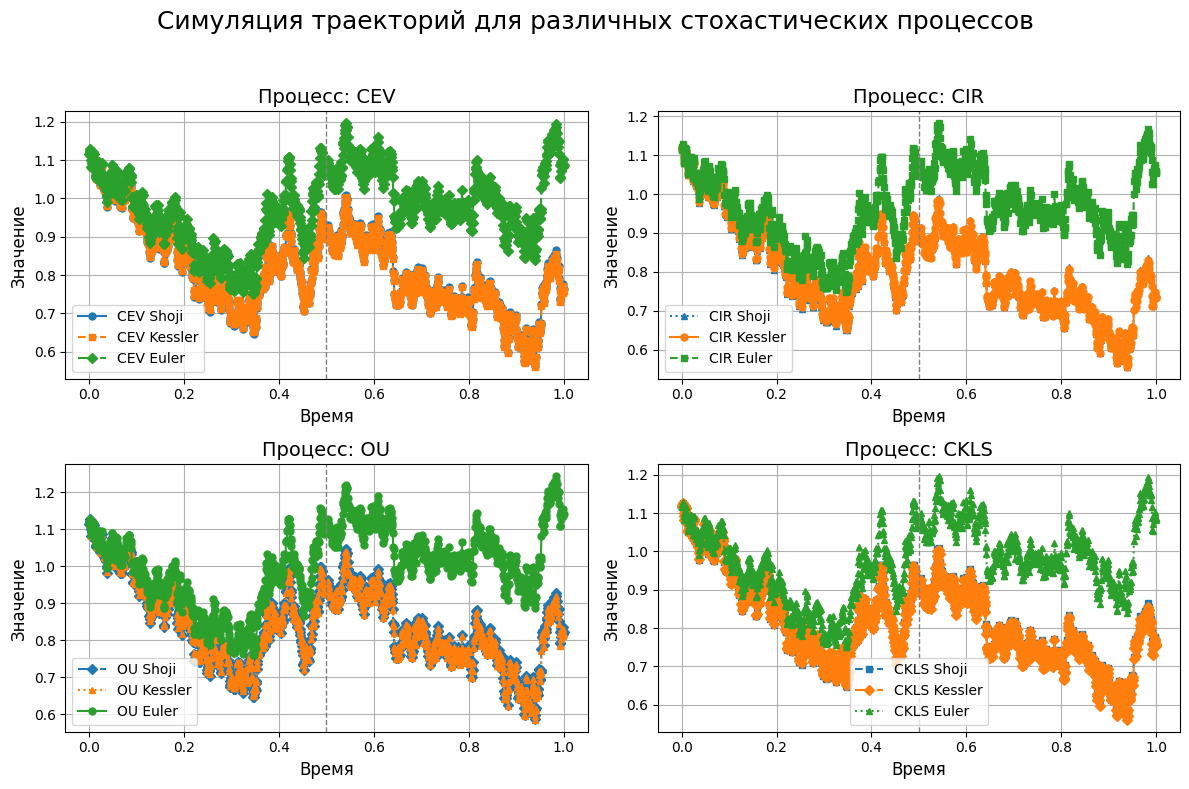

In [24]:
import matplotlib.pyplot as plt

# Увеличим размер графика и шрифты
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Симуляция траекторий для различных стохастических процессов', fontsize=18)

# Названия процессов и настройка осей
process_names = ['CEV', 'CIR', 'OU', 'CKLS']
subplots_axes = {process: ax for process, ax in zip(process_names, axes.flatten())}
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^']

# Итерация по каждому процессу и настройка графиков
for idx, process in enumerate(process_names):
    ax = subplots_axes[process]
    for i, (key, path) in enumerate(paths.items()):
        if key.startswith(process):
            style = line_styles[i % len(line_styles)]
            marker = markers[i % len(markers)]
            ax.plot(
                simulator.time_line, path,
                linestyle=style, marker=marker,
                label=key, linewidth=1.5, markersize=5
            )
    # Настройки графика
    ax.set_title(f'Процесс: {process}', fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Значение', fontsize=12)
    ax.axvline(x=T/2, color='gray', linestyle='--', linewidth=1)  # Вертикальная линия в момент T/2
    ax.legend(fontsize=10)
    ax.grid(True)

# Уплотним расположение графиков
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [35]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]



estimator = ParametrEstimator(exchange_rates, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: 4215.288351871408
`xtol` termination condition is satisfied.
Number of iterations: 142, function evaluations: 426, CG iterations: 263, optimality: 3.22e-05, constraint violation: 0.00e+00, execution time: 0.14 s.
Final Params: [0.01001275 0.08014152]
Final Likelihood: 4833.301571132599
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -19404.191449028687


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 242, function evaluations: 1275, CG iterations: 753, optimality: 7.16e-01, constraint violation: 0.00e+00, execution time: 0.26 s.
Final Params: [0.41316026 1.08422828 0.07997066 0.01538957]
Final Likelihood: 4833.932342281441
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 4159.23861990984
`xtol` termination condition is satisfied.
Number of iterations: 113, function evaluations: 460, CG iterations: 257, optimality: 5.31e-03, constraint violation: 0.00e+00, execution time: 0.084 s.
Final Params: [1.01273601 1.10356509 0.07660012]
Final Likelihood: 4825.361811563451
Initial Params: [0.01, 0.2]
Initial Likelihood: 4102.093233189805
`xtol` termination condition is satisfied.
Number of iterations: 165, function evaluations: 507, CG iterations: 300, optimality: 3.44e-04, constraint violation: 0.00e+00, execution time: 0.12 s.
Final Params: [0.0100831  0.07348562]
Final Likelihood: 4812.789458398967
Initial Params: [0.01

Task 3. U.S. Interest Rates.

Fit a time series of IRates over the period  from 06/1964
to 12/1989 (monthly data) by CEV, CIR, OU, CKLS models. Plot the historical daily time series and three time-discretization
benchmarks:
*   Kessler method,
*   Shoji-Ozaki method,
*   Euler method

using code from previous labs. *The pymle and other libraries are prohibited.*

The parameter estimates
display in Table for each method. Calculate the AIC and BIC, and select the best model. Compare your results with paper by [Brouste et. al.](https://www.semanticscholar.org/paper/The-YUIMA-Project%3A-A-Computational-Framework-for-of-Brouste-Fukasawa/e9a4696779261dbeca55f316943307d7da5d3d1b) (page 43):

$$dX_t = (2.08 - 0.26 X_t)dt + 0.13 X^{1.44}_t dW_t.$$

Dataset: In order to obtain the data one can open browser, type the address https://rdrr.io/snippets/ and run the code in R language:



```
library(Ecdat)
data(Irates)
rates = Irates[, "r1"]; rates
plot(rates)
```



In [38]:
date = pd.read_excel('lab6.xlsx', index_col = 0)
df = np.array(date)

In [44]:
df = pd.DataFrame(data)
df = df.dropna()

df.columns = ['IRates']
date_range = pd.date_range(start="1946-12-01", end="1991-02-01", freq="MS")
df['date']= date_range
df['date']== df['date'].dt.strftime('%Y-%m')

11     True
12     True
13     True
14     True
15     True
       ... 
537    True
538    True
539    True
540    True
541    True
Name: date, Length: 531, dtype: bool

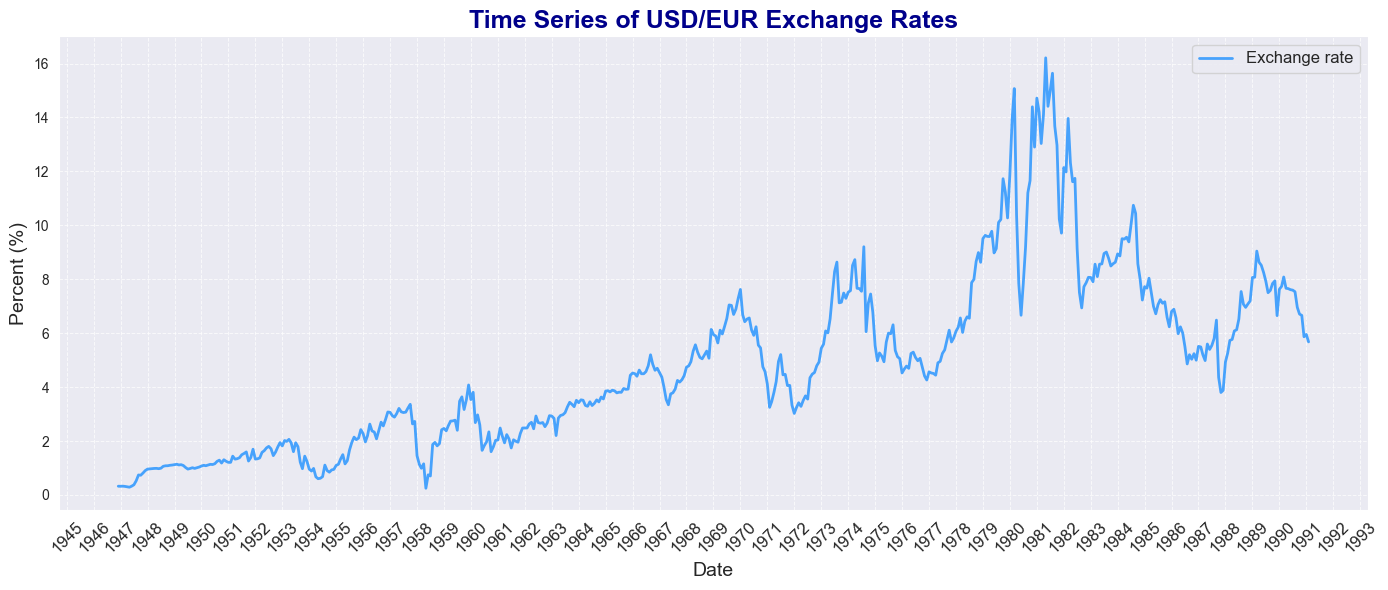

In [49]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
# Настраиваем стиль графика
sns.set_style('darkgrid')

# Создаем график
fig, ax = plt.subplots(figsize=(14, 6))

# Построение временного ряда
ax.plot(
    df['date'], df['IRates'],
    label='Exchange rate',
    color='dodgerblue',
    linewidth=2,
    alpha=0.8
)

# Форматирование оси X
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.xticks(rotation=45, fontsize=12)

# Настройки осей и заголовков
ax.set_title('Time Series of USD/EUR Exchange Rates', fontsize=18, fontweight='bold', color='darkblue')
ax.set_ylabel('Percent (%)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)

# Добавляем сетку и легенду
ax.grid(visible=True, which='both', linestyle='--', linewidth=0.7, alpha=0.7)
ax.legend(fontsize=12)

# Дополнительные настройки
plt.tight_layout()
plt.show()

In [50]:
sample1 = np.array(df['IRates'])
S0 = sample1[0]
T = 1
N = len(sample1)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}



paths = simulator.generate_paths(parameters)

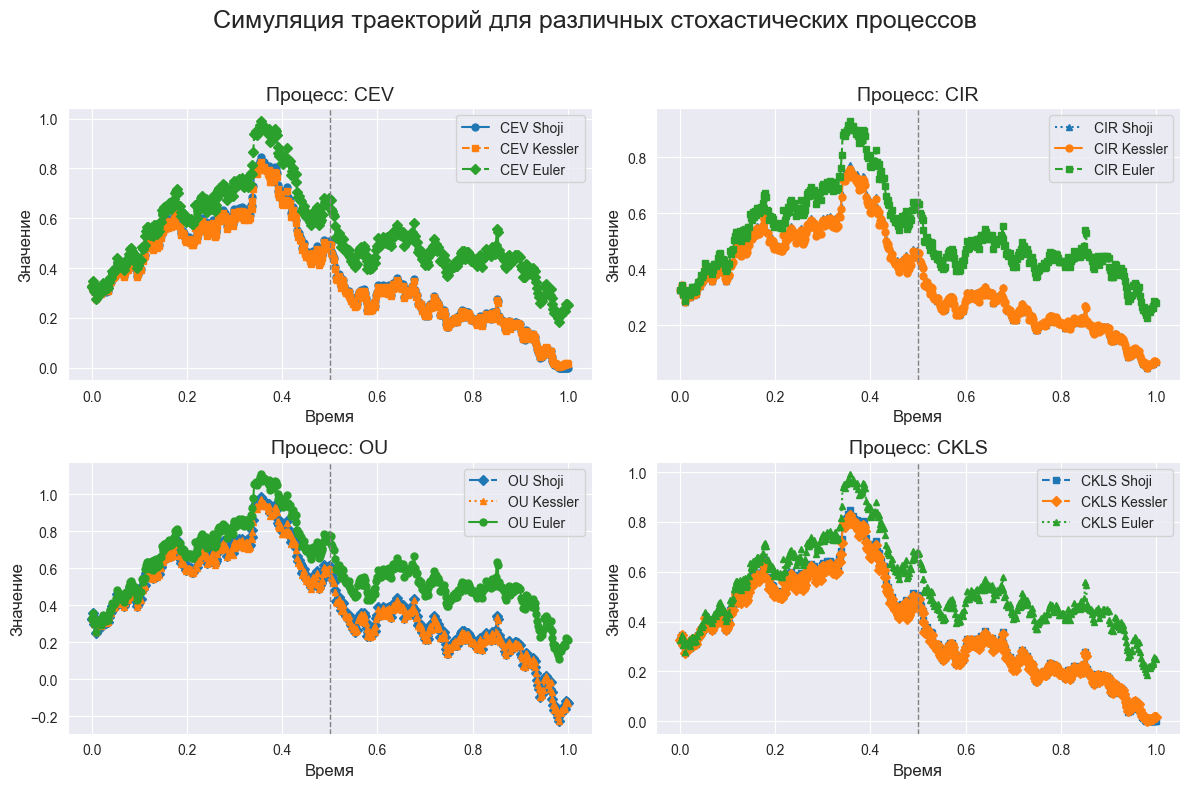

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Симуляция траекторий для различных стохастических процессов', fontsize=18)

# Названия процессов и настройка осей
process_names = ['CEV', 'CIR', 'OU', 'CKLS']
subplots_axes = {process: ax for process, ax in zip(process_names, axes.flatten())}
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^']

# Итерация по каждому процессу и настройка графиков
for idx, process in enumerate(process_names):
    ax = subplots_axes[process]
    for i, (key, path) in enumerate(paths.items()):
        if key.startswith(process):
            style = line_styles[i % len(line_styles)]
            marker = markers[i % len(markers)]
            ax.plot(
                simulator.time_line, path,
                linestyle=style, marker=marker,
                label=key, linewidth=1.5, markersize=5
            )
    # Настройки графика
    ax.set_title(f'Процесс: {process}', fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Значение', fontsize=12)
    ax.axvline(x=T/2, color='gray', linestyle='--', linewidth=1)  # Вертикальная линия в момент T/2
    ax.legend(fontsize=10)
    ax.grid(True)

# Уплотним расположение графиков
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [53]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [
    [(0.01, 10), (0.01, 2)],                         # Brownian Motion
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # CIR
    [(0.01, 10), (0.01, 2)],                         # GBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # IGBM
    [(0.01, 10), (0.01, 10), (0.01, 2)],              # OU
    [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
]

param_guess = [
    [0.01, 0.2],                                     # Brownian Motion
    [0.01, 0.01, 0.01, 0.2],                         # CEV
    [0.01, 0.01, 0.2],                               # CIR
    [0.01, 0.2],                                     # GBM
    [0.01, 0.01, 0.2],                               # IGBM
    [0.01, 0.01, 0.2],                               # OU
    [0.01, 0.01, 0.01, 0.2]                          # CKLS
]


# Initialize the ModelEstimator
estimator = ParametrEstimator(sample1, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899043825
`xtol` termination condition is satisfied.
Number of iterations: 32, function evaluations: 87, CG iterations: 37, optimality: 3.02e-03, constraint violation: 0.00e+00, execution time: 0.042 s.
Final Params: [8.29867086 1.99999964]
Final Likelihood: -3404.7460281260696
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35672.5169125899
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 230, CG iterations: 97, optimality: 3.45e+02, constraint violation: 0.00e+00, execution time: 0.037 s.
Final Params: [0.42927723 0.43311147 1.34725874 1.09677815]
Final Likelihood: -496.07075810614856
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: -18252.900715605694
`xtol` termination condition is satisfied.
Number of iterations: 60, function evaluations: 272, CG iterations: 119, optimality: 8.32e-03, constraint violation: 0.00e+00, execution time: 0.04 s.
Final Params: [3.7073358 

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 56, function evaluations: 268, CG iterations: 75, optimality: 1.15e+00, constraint violation: 0.00e+00, execution time: 0.037 s.
Final Params: [1.39953277 9.41279971 1.99999097]
Final Likelihood: -3403.088993589068
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: -35662.22063715826
`xtol` termination condition is satisfied.
Number of iterations: 38, function evaluations: 245, CG iterations: 78, optimality: 1.46e+02, constraint violation: 0.00e+00, execution time: 0.031 s.
Final Params: [0.38622293 0.38789711 1.21133823 0.96204718]
Final Likelihood: -568.3060240066428
Initial Params: [0.01, 0.2]
Initial Likelihood: -24674.766899037822
`gtol` termination condition is satisfied.
Number of iterations: 23, function evaluations: 54, CG iterations: 28, optimality: 1.51e-07, constraint violation: 0.00e+00, execution time: 0.014 s.
Final Params: [8.29612506 1.99999999]
Final Likelihood: -3404.745258528272
Initial Params

Task 4.

Take a dual-listed security (for instance, Apple, Google, Amazon), which trade simultaneously on two exchanges. Fit a time series of spread over the 5 years period (day data) by CEV, CIR, OU, CKLS models.

For example, one can use the paper by [Bertram, 2009](https://https://www.sciencedirect.com/science/article/pii/S0378437109002829)
where a spread constructed on the dual-listed security, ANZ Bank (ANZ). Calculate the AIC and BIC, and select the best model.

Hint. Use refs for selection a dual-listed security. Calculate the AIC and BIC, and select the best model.

https://live.euronext.com/en/product/equities/US0378331005-MTAH

https://stockanalysis.com/list/indian-stocks-us/

In [54]:
pip install yfinance

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 939.5/939.5 kB 4.4 MB/s eta 0:00:00m-:--:--
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 16.8 MB/s eta 0:00:00a 0:00:01
  Created wheel for peewee: filename=peewee-3.17.7-cp312-cp312-macosx_14_0_arm64.whl size=274062 sha256=ec16b302ac03991efaefdae3eb8e50f36be022b5852ffee53a1f725728177ea2
  Stored in directory: /Users/ekaterina/Library/Caches/pip/wheels/d8/b7/b5/bc5cfc21613ff88ce55cf4151a9f32e23bd8f4a2c4d51e7c8b
Successfully built peewee

[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [59]:
import pandas as pd
import yfinance as yf

# Проверка типов
print("Тип pd:", type(pd))
print("Тип pd.concat:", type(pd.concat))
print("Тип yf:", type(yf))

Тип pd: <class 'module'>
Тип pd.concat: <class 'function'>
Тип yf: <class 'module'>


In [61]:
pip install --upgrade yfinance


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: /opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [86]:
import yfinance as yf
import pandas as pd

ptr = yf.Ticker("RIO")
ptr_hist = ptr.history(period='max', interval='1d')

hk = yf.Ticker("RIO.AX")
hk_hist = hk.history(period='max', interval='1d')
ptr_hist.index = pd.to_datetime(ptr_hist.index).date
hk_hist.index = pd.to_datetime(hk_hist.index).date

ptr_hist = ptr_hist[['Close']].rename(columns={'Close': 'Close_US'})
hk_hist = hk_hist[['Close']].rename(columns={'Close': 'Close_AU'})

merged_hist = pd.merge(ptr_hist, hk_hist, left_index=True, right_index=True, how='inner')

spread = (merged_hist['Close_US'] - merged_hist['Close_AU']).abs()

In [87]:
spread

1990-06-28     1.072668
1990-06-29     1.091540
1990-07-02     1.097377
1990-07-03     1.091540
1990-07-05     1.161589
                ...    
2024-11-04    54.729996
2024-11-05    53.919998
2024-11-06    54.049995
2024-11-07    54.190002
2024-11-08    58.879997
Length: 8554, dtype: float64

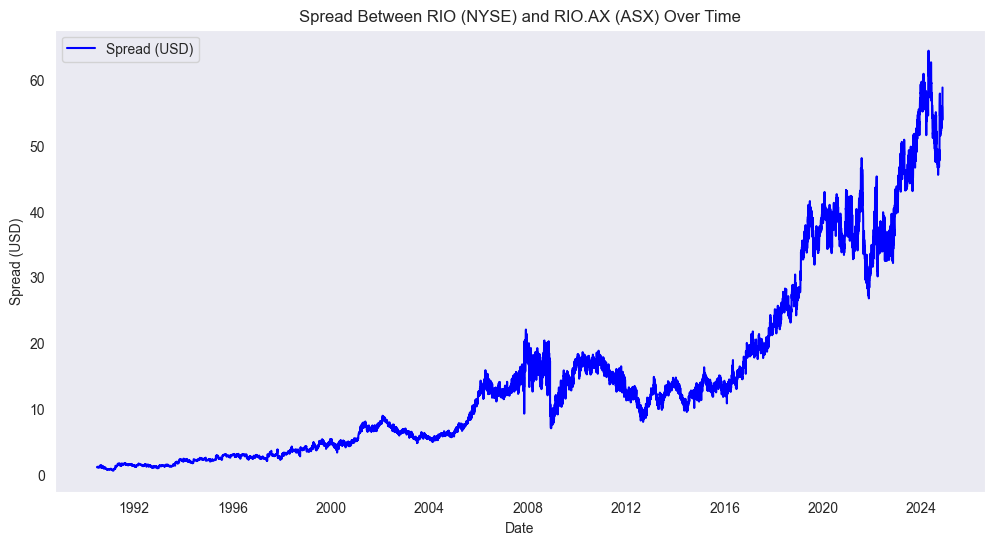

In [88]:
plt.figure(figsize=(12, 6))
plt.plot(spread.index, spread, label='Spread (USD)', color='blue', linewidth=1.5)
plt.title('Spread Between RIO (NYSE) and RIO.AX (ASX) Over Time')
plt.xlabel('Date')
plt.ylabel('Spread (USD)')
plt.legend()
plt.grid()
plt.show()

In [90]:
S0 = spread[0]
T = 1
N = len(spread)
simulator = StochasticProcessSimulator(S0, T, N)

shoji_ozaki_p = [0.01190742, 0.6541825, 0.57703004, 0.32514395]
kessler_p     = [0.02011782, 0.13874663, 0.567096, 0.33594728]
euler_p       = [0.06504598, 5.87897445, 0.57674668, 0.32538039]

parameters = {
    'CEV Shoji': shoji_ozaki_p,
    'CEV Kessler': kessler_p,
    'CEV Euler': euler_p,
    'CIR Shoji': shoji_ozaki_p[:3],
    'CIR Kessler': kessler_p[:3],
    'CIR Euler': euler_p[:3],
    'OU Shoji': shoji_ozaki_p[:3],
    'OU Kessler': kessler_p[:3],
    'OU Euler': euler_p[:3],
    'CKLS Shoji': shoji_ozaki_p,
    'CKLS Kessler': kessler_p,
    'CKLS Euler': euler_p,
}



paths = simulator.generate_paths(parameters)

/var/folders/2r/7hzr4hy17g11fkmth1lp7_tm0000gn/T/ipykernel_1412/829671652.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  S0 = spread[0]


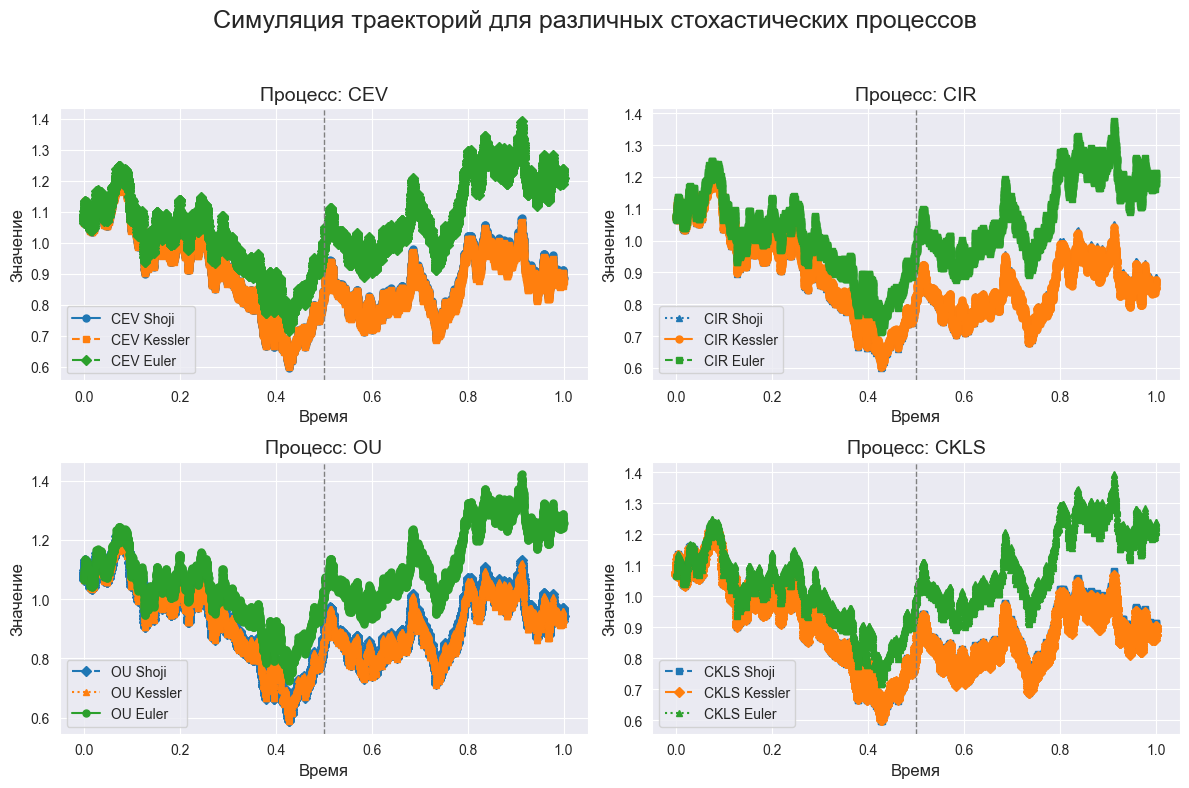

In [91]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
fig.suptitle('Симуляция траекторий для различных стохастических процессов', fontsize=18)

# Названия процессов и настройка осей
process_names = ['CEV', 'CIR', 'OU', 'CKLS']
subplots_axes = {process: ax for process, ax in zip(process_names, axes.flatten())}
line_styles = ['-', '--', '-.', ':']
markers = ['o', 's', 'D', '^']

# Итерация по каждому процессу и настройка графиков
for idx, process in enumerate(process_names):
    ax = subplots_axes[process]
    for i, (key, path) in enumerate(paths.items()):
        if key.startswith(process):
            style = line_styles[i % len(line_styles)]
            marker = markers[i % len(markers)]
            ax.plot(
                simulator.time_line, path,
                linestyle=style, marker=marker,
                label=key, linewidth=1.5, markersize=5
            )
    # Настройки графика
    ax.set_title(f'Процесс: {process}', fontsize=14)
    ax.set_xlabel('Время', fontsize=12)
    ax.set_ylabel('Значение', fontsize=12)
    ax.axvline(x=T/2, color='gray', linestyle='--', linewidth=1)  # Вертикальная линия в момент T/2
    ax.legend(fontsize=10)
    ax.grid(True)

# Уплотним расположение графиков
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

In [96]:
model_name = ["BrownianMotion", "CEV", "CIR", "GeometricBM", "IGBM", "OrnsteinUhlenbeck", "CKLS"]

model = [BrownianMotion(), CEV(), CIR(), GeometricBM(), IGBM(), OrnsteinUhlenbeck(), CKLS()]

param_bounds = [[(0.01, 10), (0.01, 2)],                         # Brownian Motion
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)], # CEV
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # CIR
                [(0.01, 10), (0.01, 2)],                         # GBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # IGBM
                [(0.01, 10), (0.01, 10),(0.01, 2)],              # OU
                [(0.01, 10), (0.01, 10), (0.01, 10), (0.01, 2)]  # CKLS
               ]

param_guess  = [[0.01, 0.2],                                     # Brownian Motion
                [0.01, 0.01, 0.01, 0.2],                         # CEV
                [0.01, 0.01, 0.2],                               # CIR
                [0.01, 0.2],                                     # GBM
                [0.01, 0.01, 0.2],                               # IGBM
                [0.01, 0.01, 0.2],                               # OU
                [0.01, 0.01, 0.01, 0.2]                          # CKLS
               ]


# Initialize the ModelEstimator
estimator = ParametrEstimator(spread, model, model_name, param_bounds, param_guess)

estimator.fit_models()
estimator.print_aic_bic_results()
estimator.print_best_model()
estimator.print_combined_results()

Initial Params: [0.01, 0.2]
Initial Likelihood: 29548.947047299323


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear

`xtol` termination condition is satisfied.
Number of iterations: 64, function evaluations: 240, CG iterations: 79, optimality: 4.51e-01, constraint violation: 0.00e+00, execution time: 0.58 s.
Final Params: [0.02116189 0.01000009]
Final Likelihood: 55092.42589937633
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: 49736.86962899454


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`xtol` termination condition is satisfied.
Number of iterations: 93, function evaluations: 495, CG iterations: 163, optimality: 4.60e+02, constraint violation: 0.00e+00, execution time:  1.5 s.
Final Params: [0.01000008 0.42857564 0.01198953 0.01000684]
Final Likelihood: 49155.546822741926
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 20252.403360860513


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear

`xtol` termination condition is satisfied.
Number of iterations: 62, function evaluations: 320, CG iterations: 138, optimality: 1.78e+00, constraint violation: 0.00e+00, execution time: 0.86 s.
Final Params: [0.01000026 0.3637708  0.0100001 ]
Final Likelihood: 45639.47413394882
Initial Params: [0.01, 0.2]
Initial Likelihood: 10945.442437921727
`gtol` termination condition is satisfied.
Number of iterations: 31, function evaluations: 93, CG iterations: 39, optimality: 2.33e-08, constraint violation: 0.00e+00, execution time: 0.24 s.
Final Params: [0.01000161 0.01000006]
Final Likelihood: 36560.965412819445
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 10945.780586063303
`xtol` termination condition is satisfied.
Number of iterations: 49, function evaluations: 228, CG iterations: 55, optimality: 1.18e+00, constraint violation: 0.00e+00, execution time: 0.53 s.
Final Params: [0.01003118 1.82061445 0.01000012]
Final Likelihood: 36568.00259548761
Initial Params: [0.01, 0.01, 0.2]
In

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear

`xtol` termination condition is satisfied.
Number of iterations: 90, function evaluations: 436, CG iterations: 142, optimality: 3.76e-02, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.01000012 0.015118   0.01260362]
Final Likelihood: 48912.690500020566
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: 49575.58577275325
`xtol` termination condition is satisfied.
Number of iterations: 71, function evaluations: 380, CG iterations: 126, optimality: 4.65e+00, constraint violation: 0.00e+00, execution time:  1.1 s.
Final Params: [0.01000311 0.01000025 0.01000042 0.14236176]
Final Likelihood: 49764.34548079527
Initial Params: [0.01, 0.2]
Initial Likelihood: 29548.947048733986


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear

`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 93, CG iterations: 43, optimality: 9.04e-10, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.01000593 0.01000003]
Final Likelihood: 55151.477306294204
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: 49736.94290398072


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 53, function evaluations: 245, CG iterations: 80, optimality: 3.28e-07, constraint violation: 0.00e+00, execution time: 0.68 s.
Final Params: [0.01       9.99999959 0.01       0.03919195]
Final Likelihood: 51701.509465154944
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 20253.474884976313
`gtol` termination condition is satisfied.
Number of iterations: 24, function evaluations: 96, CG iterations: 41, optimality: 8.19e-07, constraint violation: 0.00e+00, execution time: 0.23 s.
Final Params: [0.01000049 0.01000817 0.01000042]
Final Likelihood: 45627.78619964775
Initial Params: [0.01, 0.2]
Initial Likelihood: 10958.63604146126


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 33, function evaluations: 105, CG iterations: 46, optimality: 2.93e-07, constraint violation: 0.00e+00, execution time: 0.25 s.
Final Params: [0.0100033  0.01000011]
Final Likelihood: 36561.10518599117
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 10958.975579774082
`xtol` termination condition is satisfied.
Number of iterations: 40, function evaluations: 180, CG iterations: 56, optimality: 1.21e-03, constraint violation: 0.00e+00, execution time: 0.44 s.
Final Params: [0.01000006 1.99333204 0.01      ]
Final Likelihood: 36568.474249767314
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 29532.165888273208
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 120, CG iterations: 49, optimality: 6.55e-07, constraint violation: 0.00e+00, execution time: 0.29 s.
Final Params: [0.01000004 9.99993101 0.01000018]
Final Likelihood: 51585.16700321151
Initial Params: [0.01, 0.01, 0

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


The maximum number of function evaluations is exceeded.
Number of iterations: 250, function evaluations: 1255, CG iterations: 364, optimality: 3.35e+02, constraint violation: 0.00e+00, execution time:  3.2 s.
Final Params: [0.01010226 0.01015044 0.05952854 0.01000262]
Final Likelihood: 39528.47746254237
Initial Params: [0.01, 0.2]
Initial Likelihood: 29548.947048733986
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 90, CG iterations: 43, optimality: 9.95e-10, constraint violation: 0.00e+00, execution time: 0.17 s.
Final Params: [0.01000594 0.01000003]
Final Likelihood: 55151.4774245733
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: 49736.77322233903


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 87, function evaluations: 420, CG iterations: 176, optimality: 3.92e-07, constraint violation: 0.00e+00, execution time: 0.82 s.
Final Params: [0.01       9.99999596 0.01       0.039192  ]
Final Likelihood: 51701.339160416865
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 20253.30520355809


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear

`xtol` termination condition is satisfied.
Number of iterations: 54, function evaluations: 236, CG iterations: 96, optimality: 9.22e-05, constraint violation: 0.00e+00, execution time: 0.45 s.
Final Params: [0.01       4.88525994 0.01      ]
Final Likelihood: 45710.53491831374
Initial Params: [0.01, 0.2]
Initial Likelihood: 10958.805725123866
`gtol` termination condition is satisfied.
Number of iterations: 30, function evaluations: 96, CG iterations: 43, optimality: 9.04e-10, constraint violation: 0.00e+00, execution time: 0.18 s.
Final Params: [0.01000593 0.01000003]
Final Likelihood: 36561.335982017845
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 10958.805898355931


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)


`gtol` termination condition is satisfied.
Number of iterations: 34, function evaluations: 108, CG iterations: 45, optimality: 3.82e-07, constraint violation: 0.00e+00, execution time: 0.21 s.
Final Params: [0.01       1.99306248 0.01      ]
Final Likelihood: 36568.304894064386
Initial Params: [0.01, 0.01, 0.2]
Initial Likelihood: 29531.99620685284
`gtol` termination condition is satisfied.
Number of iterations: 83, function evaluations: 328, CG iterations: 120, optimality: 2.89e-07, constraint violation: 0.00e+00, execution time: 0.64 s.
Final Params: [0.01000003 9.99988513 0.0100001 ]
Final Likelihood: 51585.00814188627
Initial Params: [0.01, 0.01, 0.01, 0.2]
Initial Likelihood: 49575.71167130293
`xtol` termination condition is satisfied.
Number of iterations: 78, function evaluations: 415, CG iterations: 158, optimality: 2.12e-05, constraint violation: 0.00e+00, execution time: 0.81 s.
Final Params: [0.01       0.01       0.01       0.14232854]
Final Likelihood: 49764.91506457214

A

/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(self.x - self.x_prev, self.g - self.g_prev)
/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning: delta_grad == 0.0. Check if the approximated function is linear